# Description

It analyzes different strategies to take the genes from GTEx data with the highest variability, being this variability measured with different strategies: variance (`var`), coefficient of variation (`cv`) and mean absolute variation (`mad`) applied on two different versions of the data: 1) the raw TPM-normalized gene expression data (here refered to as `raw`), and 2) the log2-transformed version of the raw data (here refered to as `log2`).

# Modules

In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from tqdm import tqdm

from clustermatch import conf

# Settings

In [2]:
N_TOP_GENES_MAX_VARIANCE = 5000

# Paths

In [3]:
INPUT_DIR = conf.GTEX["DATA_DIR"] / "data_by_tissue"
display(INPUT_DIR)

PosixPath('/opt/data/data/gtex_v8/data_by_tissue')

In [4]:
OUTPUT_DIR = conf.GTEX["GENE_SELECTION_DIR"]
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_DIR)

PosixPath('/opt/data/results/gtex_v8/gene_selection')

# Functions

In [5]:
PCA_OPTIONS = {
    "n_components": 5,
    "random_state": 0,
}

In [6]:
def standardize(data):
    return pd.DataFrame(
        data=scale(data),
        index=data.index.copy(),
        columns=data.columns.copy(),
    )

In [7]:
def plot_pca(data, std=True):
    if std:
        data = standardize(data)

    clf = PCA(**PCA_OPTIONS)
    pca_data = clf.fit_transform(data)

    pca_data = pd.DataFrame(
        data=pca_data,
        index=data.index.copy(),
        columns=[f"PCA{i+1}" for i in range(pca_data.shape[1])],
    )

    g = sns.pairplot(data=pca_data)
    display(g)

# Compare different criteria to select highly variable genes

In [8]:
# I will store here the top genes selected by each method
top_genes_var = {}

## Get test data

In [9]:
test_data = pd.read_pickle(INPUT_DIR / "gtex_v8_data_whole_blood.pkl")

In [10]:
test_data.shape

(56200, 755)

In [11]:
test_data.head()

,GTEX-111YS-0006-SM-5NQBE,GTEX-1122O-0005-SM-5O99J,GTEX-1128S-0005-SM-5P9HI,GTEX-113IC-0006-SM-5NQ9C,GTEX-113JC-0006-SM-5O997,GTEX-117XS-0005-SM-5PNU6,GTEX-117YW-0005-SM-5NQ8Z,GTEX-1192W-0005-SM-5NQBQ,GTEX-1192X-0005-SM-5NQC3,GTEX-11DXW-0006-SM-5NQ7Y,...,GTEX-ZVE2-0006-SM-51MRW,GTEX-ZVP2-0005-SM-51MRK,GTEX-ZVT2-0005-SM-57WBW,GTEX-ZVT3-0006-SM-51MT9,GTEX-ZVT4-0006-SM-57WB8,GTEX-ZVTK-0006-SM-57WBK,GTEX-ZVZP-0006-SM-51MSW,GTEX-ZVZQ-0006-SM-51MR8,GTEX-ZXES-0005-SM-57WCB,GTEX-ZXG5-0005-SM-57WCN
gene_ens_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,0.02171,0.03015,0.0203,0.1675,0.02104,0.02537,0.02492,0.06809,0.0000,0.02443,...,0.0000,0.04841,0.00000,0.000,0.04858,0.11450,0.02417,0.000,0.02128,0.0000
ENSG00000227232.5,1.55500,2.74700,4.4410,10.4700,1.28700,3.13800,4.21700,2.09800,0.3579,4.26200,...,0.8979,3.06700,2.46400,1.504,3.19400,2.90600,3.43000,4.169,2.74300,6.0720
ENSG00000278267.1,0.00000,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000,0.00000,0.0000,0.62120,...,0.0000,0.00000,0.65930,0.000,0.00000,0.00000,0.00000,0.000,0.00000,0.6112
ENSG00000243485.5,0.00000,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000,0.04532,0.0000,0.00000,...,0.0000,0.00000,0.00000,0.000,0.09698,0.11430,0.00000,0.000,0.00000,0.0000
ENSG00000237613.2,0.00000,0.00000,0.0576,0.0000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,...,0.0000,0.00000,0.03678,0.000,0.00000,0.04058,0.00000,0.000,0.00000,0.0000


## Get test data in log2

In [12]:
log2_test_data = np.log2(test_data)

In [13]:
log2_test_data.head()

,GTEX-111YS-0006-SM-5NQBE,GTEX-1122O-0005-SM-5O99J,GTEX-1128S-0005-SM-5P9HI,GTEX-113IC-0006-SM-5NQ9C,GTEX-113JC-0006-SM-5O997,GTEX-117XS-0005-SM-5PNU6,GTEX-117YW-0005-SM-5NQ8Z,GTEX-1192W-0005-SM-5NQBQ,GTEX-1192X-0005-SM-5NQC3,GTEX-11DXW-0006-SM-5NQ7Y,...,GTEX-ZVE2-0006-SM-51MRW,GTEX-ZVP2-0005-SM-51MRK,GTEX-ZVT2-0005-SM-57WBW,GTEX-ZVT3-0006-SM-51MT9,GTEX-ZVT4-0006-SM-57WB8,GTEX-ZVTK-0006-SM-57WBK,GTEX-ZVZP-0006-SM-51MSW,GTEX-ZVZQ-0006-SM-51MR8,GTEX-ZXES-0005-SM-57WCB,GTEX-ZXG5-0005-SM-57WCN
gene_ens_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,-5.525496,-5.051698,-5.622376,-2.577767,-5.570721,-5.300733,-5.326552,-3.876413,-inf,-5.355202,...,-inf,-4.368551,-inf,-inf,-4.363494,-3.126580,-5.370639,-inf,-5.554358,-inf
ENSG00000227232.5,0.636915,1.457857,2.150885,3.388190,0.364012,1.649845,2.076217,1.069015,-1.482372,2.091531,...,-0.155373,1.616828,1.301002,0.588805,1.675364,1.539035,1.778209,2.059701,1.455755,2.602172
ENSG00000278267.1,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-0.686870,...,-inf,-inf,-0.600993,-inf,-inf,-inf,-inf,-inf,-inf,-0.710284
ENSG00000243485.5,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-4.463708,-inf,-inf,...,-inf,-inf,-inf,-inf,-3.366169,-3.129103,-inf,-inf,-inf,-inf
ENSG00000237613.2,-inf,-inf,-4.117787,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-inf,-inf,-4.764935,-inf,-inf,-4.623087,-inf,-inf,-inf,-inf


In [14]:
def replace_by_minimum(sample_data):
    """Replaces the -np.inf values in a pandas series by [the minimum non-inf value in it] * 1.3."""

    sample_min_values = sample_data.replace(-np.inf, np.nan).dropna().sort_values()
    sample_min = sample_min_values.iloc[0]

    return sample_data.replace(-np.inf, sample_min * 1.3)

In [15]:
assert (
    log2_test_data.iloc[:, [0]]
    .apply(replace_by_minimum)
    .squeeze()
    .loc["ENSG00000278267.1"]
    .round(5)
    == -14.76284
)

In [16]:
log2_test_data = log2_test_data.apply(replace_by_minimum)

In [17]:
log2_test_data.shape

(56200, 755)

In [18]:
log2_test_data.head()

,GTEX-111YS-0006-SM-5NQBE,GTEX-1122O-0005-SM-5O99J,GTEX-1128S-0005-SM-5P9HI,GTEX-113IC-0006-SM-5NQ9C,GTEX-113JC-0006-SM-5O997,GTEX-117XS-0005-SM-5PNU6,GTEX-117YW-0005-SM-5NQ8Z,GTEX-1192W-0005-SM-5NQBQ,GTEX-1192X-0005-SM-5NQC3,GTEX-11DXW-0006-SM-5NQ7Y,...,GTEX-ZVE2-0006-SM-51MRW,GTEX-ZVP2-0005-SM-51MRK,GTEX-ZVT2-0005-SM-57WBW,GTEX-ZVT3-0006-SM-51MT9,GTEX-ZVT4-0006-SM-57WB8,GTEX-ZVTK-0006-SM-57WBK,GTEX-ZVZP-0006-SM-51MSW,GTEX-ZVZQ-0006-SM-51MR8,GTEX-ZXES-0005-SM-57WCB,GTEX-ZXG5-0005-SM-57WCN
gene_ens_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,-5.525496,-5.051698,-5.622376,-2.577767,-5.570721,-5.300733,-5.326552,-3.876413,-13.607926,-5.355202,...,-14.387195,-4.368551,-13.129928,-12.549055,-4.363494,-3.126580,-5.370639,-13.882882,-5.554358,-14.571833
ENSG00000227232.5,0.636915,1.457857,2.150885,3.388190,0.364012,1.649845,2.076217,1.069015,-1.482372,2.091531,...,-0.155373,1.616828,1.301002,0.588805,1.675364,1.539035,1.778209,2.059701,1.455755,2.602172
ENSG00000278267.1,-14.762838,-12.440512,-12.420665,-12.241911,-16.122272,-12.751363,-12.444793,-13.522272,-13.607926,-0.686870,...,-14.387195,-12.320450,-0.600993,-12.549055,-14.552398,-13.087798,-12.501345,-13.882882,-11.801737,-0.710284
ENSG00000243485.5,-14.762838,-12.440512,-12.420665,-12.241911,-16.122272,-12.751363,-12.444793,-4.463708,-13.607926,-13.241663,...,-14.387195,-12.320450,-13.129928,-12.549055,-3.366169,-3.129103,-12.501345,-13.882882,-11.801737,-14.571833
ENSG00000237613.2,-14.762838,-12.440512,-4.117787,-12.241911,-16.122272,-12.751363,-12.444793,-13.522272,-13.607926,-13.241663,...,-14.387195,-12.320450,-4.764935,-12.549055,-14.552398,-4.623087,-12.501345,-13.882882,-11.801737,-14.571833


In [19]:
log2_test_data.iloc[:10, :].T.describe()

gene_ens_id,ENSG00000223972.5,ENSG00000227232.5,ENSG00000278267.1,ENSG00000243485.5,ENSG00000237613.2,ENSG00000268020.3,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.6,ENSG00000233750.3
count,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000
mean,-9.150391,1.373611,-12.842420,-11.798819,-12.018580,-11.098000,-10.051731,-9.926865,-4.106267,-0.615460
std,4.495001,1.098365,2.462041,3.534951,3.162586,3.993413,4.460360,4.536575,3.881104,2.024218
min,-17.124483,-13.270945,-17.281731,-17.281731,-17.281731,-17.281731,-17.281731,-17.124483,-17.124483,-14.328178
25%,-13.308264,0.860750,-14.020171,-13.909830,-13.874311,-13.740085,-13.580124,-13.604612,-4.965798,-1.849444
50%,-11.259655,1.404358,-13.035797,-12.856882,-12.819882,-12.653061,-12.280769,-12.278154,-3.374225,-0.330066
75%,-4.825701,2.044393,-12.252839,-11.797186,-11.878836,-10.803968,-4.775375,-4.683171,-1.657218,0.842375
max,-1.299383,4.090853,1.459432,-1.427401,-2.641154,-2.189680,-1.444969,0.975997,2.269033,3.155102


## On TPM-normalized data (raw)

### Variance

In [20]:
exp_id = "var_raw"

In [21]:
top_genes_var[exp_id] = (
    test_data.var(axis=1).sort_values(ascending=False).head(N_TOP_GENES_MAX_VARIANCE)
)

In [22]:
top_genes_var[exp_id]

gene_ens_id
ENSG00000244734.3     2.359712e+10
ENSG00000188536.12    2.212349e+09
ENSG00000163220.10    1.403840e+09
ENSG00000206172.8     1.801360e+08
ENSG00000223609.7     9.886324e+07
                          ...     
ENSG00000130517.13    6.785128e+01
ENSG00000138674.16    6.784771e+01
ENSG00000065911.11    6.778009e+01
ENSG00000163297.16    6.777261e+01
ENSG00000259865.1     6.773850e+01
Length: 5000, dtype: float64

In [23]:
selected_data = test_data.loc[top_genes_var[exp_id].index]

In [24]:
selected_data.shape

(5000, 755)

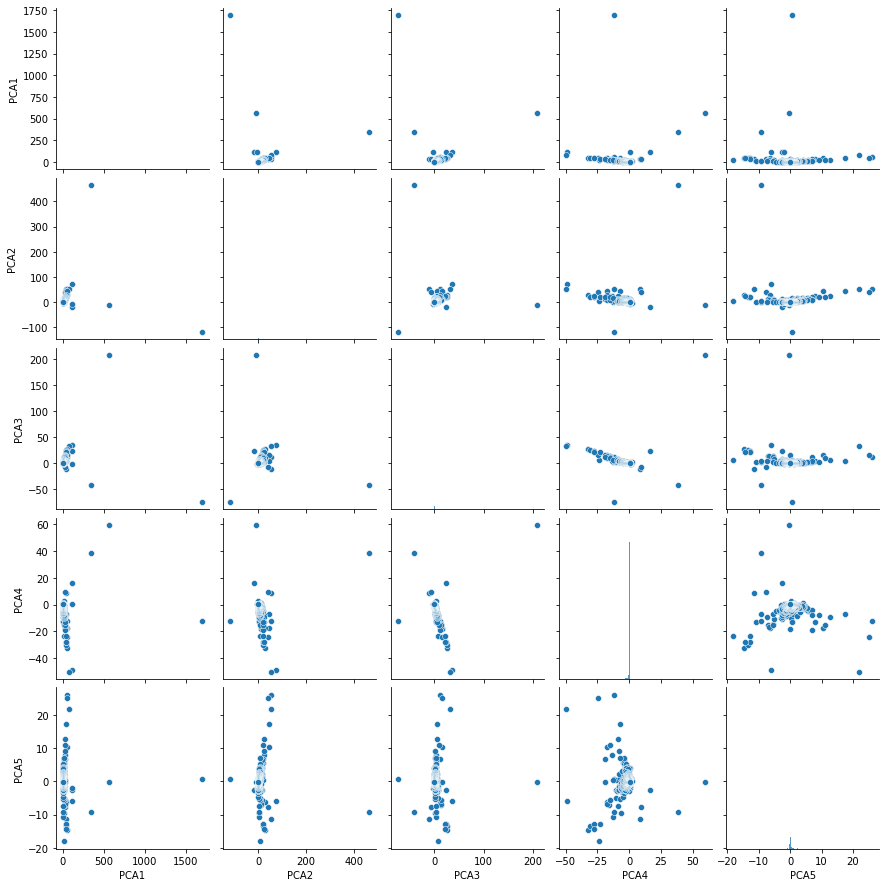

In [25]:
plot_pca(selected_data)

### Coefficient of variation

In [26]:
exp_id = "cv_raw"

In [27]:
top_genes_var[exp_id] = (
    (test_data.std(axis=1) / test_data.mean(axis=1))
    .sort_values(ascending=False)
    .head(N_TOP_GENES_MAX_VARIANCE)
)

In [28]:
top_genes_var[exp_id]

gene_ens_id
ENSG00000252644.1    27.477263
ENSG00000263890.1    27.477263
ENSG00000278945.1    27.477263
ENSG00000252750.1    27.477263
ENSG00000265168.1    27.477263
                       ...    
ENSG00000283517.1    14.829460
ENSG00000252711.1    14.828955
ENSG00000250084.1    14.825888
ENSG00000243543.8    14.822224
ENSG00000234686.1    14.819219
Length: 5000, dtype: float64

### Mean absolute variation

In [29]:
exp_id = "mad_raw"

In [30]:
top_genes_var[exp_id] = (
    test_data.mad(axis=1).sort_values(ascending=False).head(N_TOP_GENES_MAX_VARIANCE)
)

In [31]:
top_genes_var[exp_id]

gene_ens_id
ENSG00000244734.3     128806.279549
ENSG00000188536.12     38162.206489
ENSG00000163220.10     29350.347020
ENSG00000206172.8      10972.777868
ENSG00000223609.7       8083.453017
                          ...      
ENSG00000243055.1          5.824070
ENSG00000013288.8          5.823924
ENSG00000185880.12         5.822185
ENSG00000153574.8          5.817820
ENSG00000124783.12         5.814515
Length: 5000, dtype: float64

## On log2 TPM-normalized data

### Variance

In [32]:
exp_id = "var_log2"

In [33]:
top_genes_var[exp_id] = (
    log2_test_data.var(axis=1)
    .sort_values(ascending=False)
    .head(N_TOP_GENES_MAX_VARIANCE)
)

In [34]:
top_genes_var[exp_id]

gene_ens_id
ENSG00000213058.3     56.744406
ENSG00000200879.1     55.009060
ENSG00000211918.1     54.041406
ENSG00000211924.1     54.011306
ENSG00000211923.1     53.627304
                        ...    
ENSG00000232203.3     23.586464
ENSG00000250585.2     23.583676
ENSG00000271009.2     23.582607
ENSG00000167798.17    23.576509
ENSG00000236611.1     23.574472
Length: 5000, dtype: float64

In [35]:
# plot on raw
selected_data = test_data.loc[top_genes_var[exp_id].index]

In [36]:
selected_data.shape

(5000, 755)

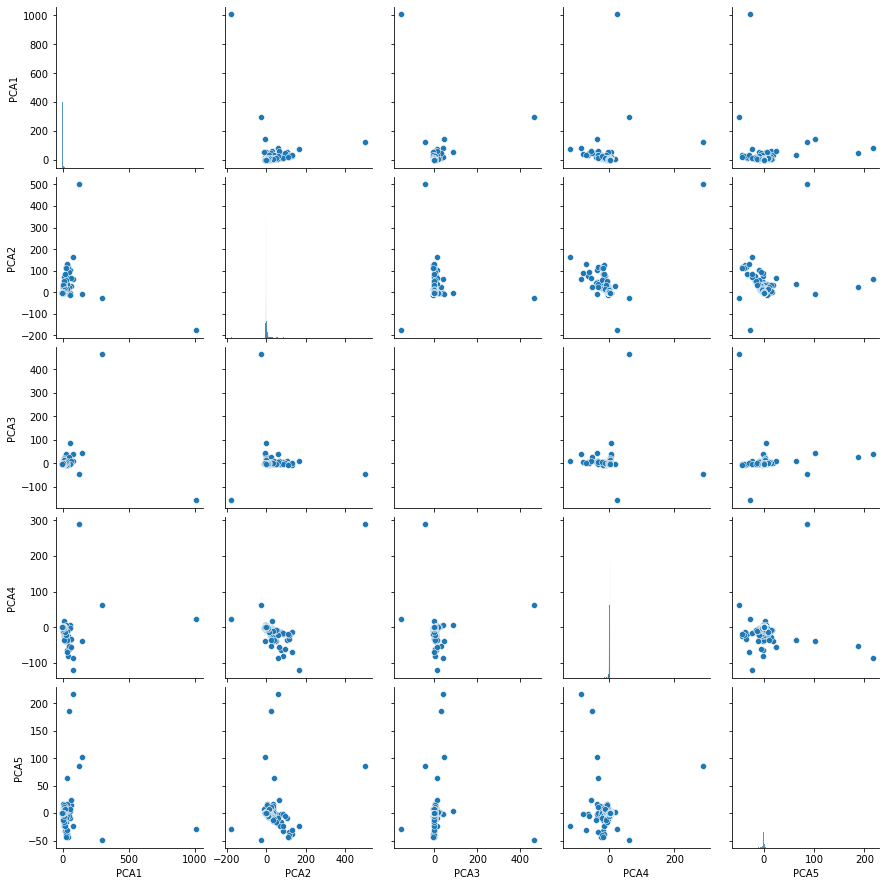

In [37]:
plot_pca(selected_data)

In [38]:
# plot on log2
selected_data = log2_test_data.loc[top_genes_var[exp_id].index]

In [39]:
selected_data.shape

(5000, 755)

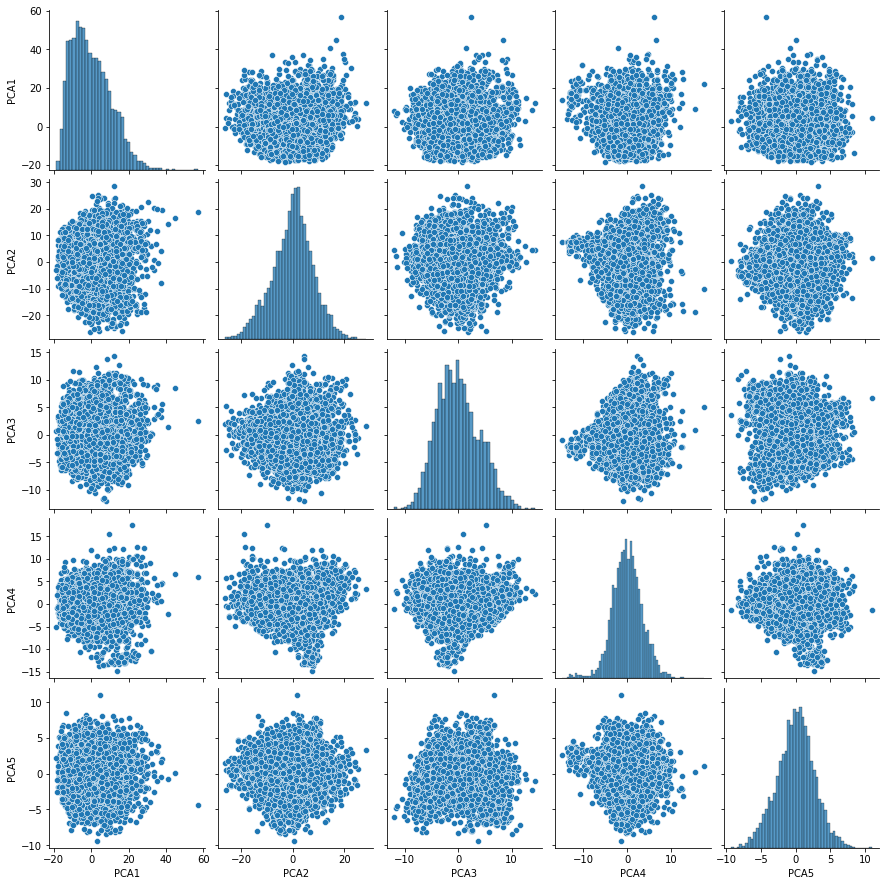

In [40]:
plot_pca(selected_data)

### Coefficient of variation

In [41]:
exp_id = "cv_log2"

In [42]:
top_genes_var[exp_id] = (
    (log2_test_data.std(axis=1) / log2_test_data.mean(axis=1))
    .sort_values(ascending=False)
    .head(N_TOP_GENES_MAX_VARIANCE)
)

In [43]:
top_genes_var[exp_id]

gene_ens_id
ENSG00000187860.10    769.530322
ENSG00000272950.1     652.098541
ENSG00000264278.1     396.844985
ENSG00000065060.16    390.844173
ENSG00000279722.1     358.806295
                         ...    
ENSG00000162148.10      0.480944
ENSG00000100483.13      0.480878
ENSG00000083312.17      0.480827
ENSG00000090006.17      0.480684
ENSG00000184260.5       0.480570
Length: 5000, dtype: float64

### Mean absolute variation

In [44]:
exp_id = "mad_log2"

In [45]:
top_genes_var[exp_id] = (
    log2_test_data.mad(axis=1)
    .sort_values(ascending=False)
    .head(N_TOP_GENES_MAX_VARIANCE)
)

In [46]:
top_genes_var[exp_id]

gene_ens_id
ENSG00000211924.1    7.234778
ENSG00000200879.1    7.225003
ENSG00000211917.1    7.007245
ENSG00000211918.1    7.003081
ENSG00000211923.1    6.882448
                       ...   
ENSG00000260031.1    4.337414
ENSG00000164122.8    4.337317
ENSG00000267607.1    4.337227
ENSG00000237294.1    4.337177
ENSG00000260017.1    4.336677
Length: 5000, dtype: float64

## Do selected genes with different methods overlap?

In [47]:
def overlap(x, y):
    ov = set(x).intersection(set(y))
    return len(ov)

In [48]:
assert overlap([1, 2, 3], [4, 5, 6]) == 0
assert overlap([1, 2, 3], [2, 3, 4]) == 2

In [49]:
genes_selection_methods = list(top_genes_var.keys())

display(genes_selection_methods)
assert len(genes_selection_methods) == 6

['var_raw', 'cv_raw', 'mad_raw', 'var_log2', 'cv_log2', 'mad_log2']

In [50]:
_gene_sets = np.array(
    [top_genes_var[x].index.tolist() for x in genes_selection_methods]
)

In [51]:
_gene_sets[:2]

array([['ENSG00000244734.3', 'ENSG00000188536.12', 'ENSG00000163220.10',
        ..., 'ENSG00000065911.11', 'ENSG00000163297.16',
        'ENSG00000259865.1'],
       ['ENSG00000252644.1', 'ENSG00000263890.1', 'ENSG00000278945.1',
        ..., 'ENSG00000250084.1', 'ENSG00000243543.8',
        'ENSG00000234686.1']], dtype='<U18')

In [52]:
assert overlap(_gene_sets[0], _gene_sets[0]) == 5000

In [53]:
_tmp = squareform(pdist(_gene_sets, metric=overlap))
np.fill_diagonal(_tmp, _gene_sets[0].shape[0])
_tmp = pd.DataFrame(
    _tmp, index=genes_selection_methods, columns=genes_selection_methods
)

display(_tmp)

,var_raw,cv_raw,mad_raw,var_log2,cv_log2,mad_log2
var_raw,5000.0,24.0,4785.0,82.0,610.0,58.0
cv_raw,24.0,5000.0,4.0,11.0,0.0,11.0
mad_raw,4785.0,4.0,5000.0,32.0,545.0,20.0
var_log2,82.0,11.0,32.0,5000.0,4.0,4346.0
cv_log2,610.0,0.0,545.0,4.0,5000.0,2.0
mad_log2,58.0,11.0,20.0,4346.0,2.0,5000.0


Some methods select very different sets of genes, particularly between `cv`, where there is no agreement between the same approach on `log2` and `raw` data.

Since they are similar, the largest overlap is between `var_*` anad `mad_*` approaches.

In [54]:
# get list of methods that agree more with the rest
(_tmp.sum() - 5000).sort_values(ascending=False)

var_raw     5559.0
mad_raw     5386.0
var_log2    4475.0
mad_log2    4437.0
cv_log2     1161.0
cv_raw        50.0
dtype: float64

# How different are genes selected by `raw` and `log2`?

Here I focus on `raw` and `log2` with the `var` (variance) method.

In [55]:
genes_df = pd.DataFrame(top_genes_var)

In [56]:
genes_df.shape

(20129, 6)

In [57]:
genes_df.head()

,var_raw,cv_raw,mad_raw,var_log2,cv_log2,mad_log2
gene_ens_id,,,,,,
ENSG00000000419.12,129.057527,NaN,9.078342,NaN,NaN,NaN
ENSG00000000457.13,NaN,NaN,NaN,NaN,0.828493,NaN
ENSG00000000938.12,175062.600067,NaN,342.304230,NaN,NaN,NaN
ENSG00000001084.10,NaN,NaN,NaN,NaN,0.683924,NaN
ENSG00000001167.14,119.196350,NaN,7.911488,NaN,NaN,NaN


In [58]:
cols = ["var_raw", "var_log2"]

## Genes select in both raw and log2

In [59]:
# show top genes selected by both var_raw and var_log2
genes_df.loc[
    top_genes_var["var_raw"].index.intersection(top_genes_var["var_log2"].index), cols
].head()

,var_raw,var_log2
gene_ens_id,,
ENSG00000163631.16,444318.094908,29.196734
ENSG00000169429.10,417015.220239,23.871169
ENSG00000149021.6,31730.980482,32.277223
ENSG00000110245.11,28328.155005,46.295538
ENSG00000156575.2,17965.513902,39.375641


In [60]:
_gene_ids = [
    "ENSG00000163631.16",  # larger in raw
    "ENSG00000110245.11",  # larger in log2
]

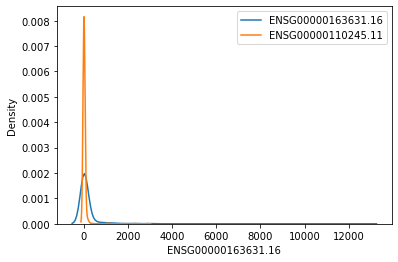

In [61]:
# plot density on raw
for gene_id in _gene_ids:
    sns.kdeplot(data=test_data.T, x=gene_id, label=gene_id)

plt.legend()

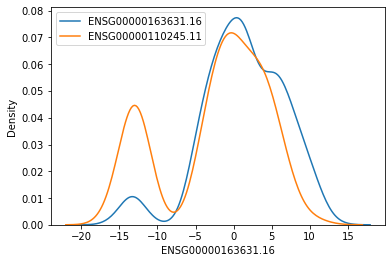

In [62]:
# same genes, but plot density on log2
for gene_id in _gene_ids:
    sns.kdeplot(data=log2_test_data.T, x=gene_id, label=gene_id)

plt.legend()

`var_log2` seems to select genes that tend to be more bimodal (with many cases around no expression and other around highly expressed), whereas `var_raw` selects genes with a unimodal distribution.

## Genes selected in raw only

In [63]:
# show top genes selected by var_raw
genes_df.loc[top_genes_var["var_raw"].index, cols].head()

,var_raw,var_log2
gene_ens_id,,
ENSG00000244734.3,2.359712e+10,NaN
ENSG00000188536.12,2.212349e+09,NaN
ENSG00000163220.10,1.403840e+09,NaN
ENSG00000206172.8,1.801360e+08,NaN
ENSG00000223609.7,9.886324e+07,NaN


In [64]:
_gene_ids = ["ENSG00000244734.3", "ENSG00000188536.12"]

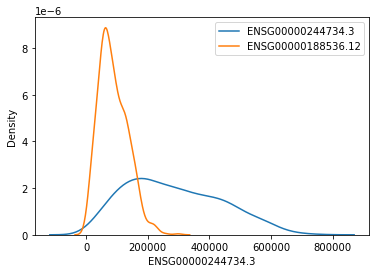

In [65]:
# plot density on raw
for gene_id in _gene_ids:
    sns.kdeplot(data=test_data.T, x=gene_id, label=gene_id)

plt.legend()

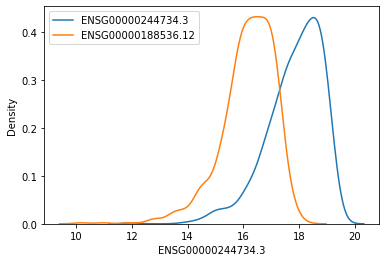

In [66]:
# same genes, but plot density on log2
for gene_id in _gene_ids:
    sns.kdeplot(data=log2_test_data.T, x=gene_id, label=gene_id)

plt.legend()

## Genes selected in log2 only

In [67]:
# show top genes selected by var_log2
genes_df.loc[top_genes_var["var_log2"].index, cols].head()

,var_raw,var_log2
gene_ens_id,,
ENSG00000213058.3,156.138018,56.744406
ENSG00000200879.1,NaN,55.009060
ENSG00000211918.1,NaN,54.041406
ENSG00000211924.1,NaN,54.011306
ENSG00000211923.1,234.065105,53.627304


In [68]:
_gene_ids = ["ENSG00000213058.3", "ENSG00000200879.1", "ENSG00000211918.1"]

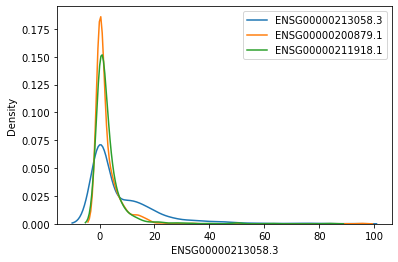

In [69]:
# plot density on raw
for gene_id in _gene_ids:
    sns.kdeplot(data=test_data.T, x=gene_id, label=gene_id)

plt.legend()

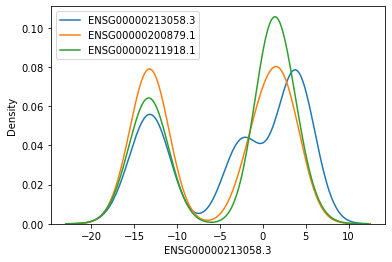

In [70]:
# same genes, but plot density on log2
for gene_id in _gene_ids:
    sns.kdeplot(data=log2_test_data.T, x=gene_id, label=gene_id)

plt.legend()

**CONCLUSION:** Both `var_raw` (that is, the strategy that selects the top genes with highest variance on raw TPM-normalized data) and `var_log2` (highest variance on log2-transformed TPM-normalized data) seem to be interesting. `var_raw` seems to select genes that are expressed around a mean, less expressed in some conditions and more expressed in others. `var_log2` tends to select genes that are not expressed (zero expression) in several conditions, and relatively highly expressed in others, which might capture important genes such as transcriptor factors (see https://www.biorxiv.org/content/10.1101/2020.02.13.944777v1).

# Select top genes for each tissue data file

Based on the previous findings, I select genes with both strategies `var_raw` and `var_log2`.

In [71]:
input_files = list(INPUT_DIR.glob("*.pkl"))
assert len(input_files) == 54, len(input_files)

display(input_files[:5])

[PosixPath('/opt/data/data/gtex_v8/data_by_tissue/gtex_v8_data_bladder.pkl'),
 PosixPath('/opt/data/data/gtex_v8/data_by_tissue/gtex_v8_data_kidney_medulla.pkl'),
 PosixPath('/opt/data/data/gtex_v8/data_by_tissue/gtex_v8_data_small_intestine_terminal_ileum.pkl'),
 PosixPath('/opt/data/data/gtex_v8/data_by_tissue/gtex_v8_data_cells_cultured_fibroblasts.pkl'),
 PosixPath('/opt/data/data/gtex_v8/data_by_tissue/gtex_v8_data_spleen.pkl')]

## Run

In [72]:
pbar = tqdm(input_files, ncols=100)

for tissue_data_file in pbar:
    pbar.set_description(tissue_data_file.stem)

    tissue_data = pd.read_pickle(tissue_data_file)

    # select top genes

    ## var_raw
    top_genes_var = (
        tissue_data.var(axis=1)
        .sort_values(ascending=False)
        .head(N_TOP_GENES_MAX_VARIANCE)
    )
    selected_tissue_data = tissue_data.loc[top_genes_var.index]

    output_filename = f"{tissue_data_file.stem}-var_raw.pkl"
    selected_tissue_data.to_pickle(path=OUTPUT_DIR / output_filename)

    ## var_log2
    log2_tissue_data = np.log2(tissue_data)
    log2_tissue_data = log2_tissue_data.apply(replace_by_minimum)

    top_genes_var = (
        log2_tissue_data.var(axis=1)
        .sort_values(ascending=False)
        .head(N_TOP_GENES_MAX_VARIANCE)
    )
    selected_tissue_data = tissue_data.loc[top_genes_var.index]

    output_filename = f"{tissue_data_file.stem}-var_log2.pkl"
    selected_tissue_data.to_pickle(path=OUTPUT_DIR / output_filename)

gtex_v8_data_kidney_cortex: 100%|███████████████████████████████████| 54/54 [02:18<00:00,  2.57s/it]


## Testing

In [73]:
_tmp_raw = pd.read_pickle(
    OUTPUT_DIR / "gtex_v8_data_brain_nucleus_accumbens_basal_ganglia-var_raw.pkl"
)
_tmp_log2 = pd.read_pickle(
    OUTPUT_DIR / "gtex_v8_data_brain_nucleus_accumbens_basal_ganglia-var_log2.pkl"
)

In [74]:
display(_tmp_raw.shape)
assert _tmp_raw.shape == _tmp_log2.shape

(5000, 246)

In [75]:
_tmp_raw.head()

,GTEX-1192X-0011-R6a-SM-DNZZB,GTEX-11DXW-0011-R6a-SM-DO11N,GTEX-11DXY-0011-R6a-SM-DNZZF,GTEX-11DYG-0011-R6a-SM-DO936,GTEX-11DZ1-0011-R6b-SM-DNZZG,GTEX-11GSP-0011-R6b-SM-57WBQ,GTEX-11NUK-0011-R6a-SM-DO93O,GTEX-11NV4-0011-R6a-SM-57WD5,GTEX-11O72-0011-R6a-SM-DNZZQ,GTEX-11OF3-0011-R6b-SM-57WBG,...,GTEX-ZAB4-0011-R6a-SM-4SOKD,GTEX-ZDXO-0011-R6a-SM-4WWCT,GTEX-ZE7O-0011-R6a-SM-57WCI,GTEX-ZE9C-0011-R6a-SM-4WWCW,GTEX-ZF28-0011-R6a-SM-4WKHI,GTEX-ZUA1-0011-R6b-SM-4YCDD,GTEX-ZV68-0011-R6a-SM-51MSR,GTEX-ZVT3-0011-R6a-SM-51MSU,GTEX-ZVZQ-0011-R6b-SM-57WAY,GTEX-ZXG5-0011-R6a-SM-57WBZ
gene_ens_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000210082.2,67110.0,70310.0,60290.0,95330.0,118800.0,110200.0,75980.0,75310.0,104200.0,71790.0,...,78280.0,76370.0,114500.0,103700.0,113700.0,72350.0,142900.0,104500.0,81270.0,80170.0
ENSG00000198804.2,45390.0,76920.0,25700.0,30030.0,23200.0,57550.0,57880.0,36770.0,68970.0,36100.0,...,53430.0,65250.0,88210.0,36870.0,74680.0,21500.0,89810.0,74760.0,64440.0,56080.0
ENSG00000198938.2,54310.0,88470.0,53420.0,48360.0,43540.0,56700.0,63270.0,66570.0,61390.0,67420.0,...,74130.0,59020.0,74080.0,54690.0,64630.0,45130.0,62720.0,69160.0,55510.0,58640.0
ENSG00000198712.1,59770.0,88700.0,66280.0,68790.0,55690.0,65060.0,55710.0,70220.0,73170.0,67930.0,...,82530.0,64840.0,71320.0,71000.0,73210.0,62330.0,76190.0,85740.0,65840.0,66580.0
ENSG00000198886.2,47670.0,61980.0,40900.0,37710.0,38030.0,53220.0,45200.0,49530.0,62210.0,50870.0,...,62940.0,54630.0,66530.0,57730.0,75000.0,42090.0,72690.0,69740.0,58210.0,55150.0


In [76]:
_tmp_desc = _tmp_raw.T.iloc[:, :5].describe()
display(_tmp_desc)

assert _tmp_desc.loc["max"].min() > 80000
assert _tmp_desc.loc["max"].min() < 205000

gene_ens_id,ENSG00000210082.2,ENSG00000198804.2,ENSG00000198938.2,ENSG00000198712.1,ENSG00000198886.2
count,246.000000,246.000000,246.000000,246.000000,246.000000
mean,81741.544715,53307.182927,59999.292683,66188.292683,53941.199187
std,24532.195989,23092.392034,13435.966413,12893.557177,12739.129287
min,37640.000000,5097.000000,4396.000000,12230.000000,5275.000000
25%,63750.000000,35272.500000,50865.000000,58352.500000,44472.500000
50%,78380.000000,48305.000000,58755.000000,66330.000000,52610.000000
75%,94987.500000,68967.500000,68395.000000,74260.000000,62310.000000
max,201000.000000,116200.000000,96860.000000,104400.000000,84080.000000


In [77]:
_tmp_log2.head()

,GTEX-1192X-0011-R6a-SM-DNZZB,GTEX-11DXW-0011-R6a-SM-DO11N,GTEX-11DXY-0011-R6a-SM-DNZZF,GTEX-11DYG-0011-R6a-SM-DO936,GTEX-11DZ1-0011-R6b-SM-DNZZG,GTEX-11GSP-0011-R6b-SM-57WBQ,GTEX-11NUK-0011-R6a-SM-DO93O,GTEX-11NV4-0011-R6a-SM-57WD5,GTEX-11O72-0011-R6a-SM-DNZZQ,GTEX-11OF3-0011-R6b-SM-57WBG,...,GTEX-ZAB4-0011-R6a-SM-4SOKD,GTEX-ZDXO-0011-R6a-SM-4WWCT,GTEX-ZE7O-0011-R6a-SM-57WCI,GTEX-ZE9C-0011-R6a-SM-4WWCW,GTEX-ZF28-0011-R6a-SM-4WKHI,GTEX-ZUA1-0011-R6b-SM-4YCDD,GTEX-ZV68-0011-R6a-SM-51MSR,GTEX-ZVT3-0011-R6a-SM-51MSU,GTEX-ZVZQ-0011-R6b-SM-57WAY,GTEX-ZXG5-0011-R6a-SM-57WBZ
gene_ens_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000226278.1,7.683,0.06962,0.0000,17.340,0.09116,0.08264,0.0000,9.829,0.00000,0.000,...,0.000,0.1128,0.000,6.245,0.09641,0.000,0.000,0.000,0.000,0.000
ENSG00000204983.13,16.420,0.27500,0.1497,3.605,0.52630,0.00000,2.7270,0.000,0.59230,0.000,...,53.970,12.7200,0.000,8.783,20.27000,10.540,0.000,4.739,0.000,0.000
ENSG00000270405.1,4.009,0.00000,0.0000,7.398,0.00000,0.00000,0.0000,4.078,0.07182,0.000,...,0.000,0.0000,0.000,2.286,0.00000,0.000,0.000,0.000,0.000,0.000
ENSG00000196408.11,1.815,0.00000,1.6480,0.000,0.91510,2.48900,2.7310,2.145,0.69880,1.092,...,0.000,2.2650,2.101,0.000,0.00000,1.106,0.000,0.000,1.428,3.031
ENSG00000211594.2,0.000,0.98220,0.5791,0.000,0.64310,1.16600,0.6396,3.015,1.47300,1.534,...,9.289,2.3870,2.953,6.394,4.08000,7.771,2.596,3.180,1.004,1.065


In [78]:
_tmp_desc = _tmp_log2.T.iloc[:, :5].describe()
display(_tmp_desc)

assert _tmp_desc.loc["max"].min() > 8
assert _tmp_desc.loc["max"].min() < 300

gene_ens_id,ENSG00000226278.1,ENSG00000204983.13,ENSG00000270405.1,ENSG00000196408.11,ENSG00000211594.2
count,246.000000,246.000000,246.000000,246.000000,246.000000
mean,3.060643,4.019499,1.261166,1.701973,2.501784
std,4.459112,19.719763,1.986484,1.949778,11.747263
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.082660,0.080780,0.000000,1.105500,0.683700
75%,5.763500,2.287250,2.030500,2.641000,1.644000
max,23.040000,292.100000,10.980000,8.824000,139.300000


In [79]:
assert _tmp_raw.columns.tolist() == _tmp_log2.columns.tolist()

In [80]:
assert len(set(_tmp_raw.index).intersection(set(_tmp_log2.index))) == 23